In [1]:
import os
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import norm

import torch
from torch import nn
import torch.optim as opt
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from livelossplot import PlotLosses


np.random.bit_generator = np.random._bit_generator


In [2]:
BATCH_SIZE = 25

transforms = transforms.Compose([transforms.Pad(2), transforms.ToTensor()])

mnist_train_data = MNIST('../data/', train=True, transform=transforms,download=True)
mnist_test_data = MNIST('../data/', train=False,transform=transforms,download=True)
train_loader = DataLoader(mnist_train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
test_loader = DataLoader(mnist_test_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

In [3]:
def conv_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv3D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

In [4]:
class VanillaVAE(nn.Module):
    

    def __init__(self,in_channels, latent_dim):
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim
        
        output_shape = (28,28)
        
        self.enc1 = nn.Sequential(
                    nn.Conv2d(1, out_channels=32,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU())
        output_shape1 = conv_output_size(output_shape,(1,1),(3,3),(2,2))

        self.enc2 = nn.Sequential(
                    nn.Conv2d(32, out_channels=64,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU())
        output_shape2 = conv_output_size(output_shape1,(1,1),(3,3),(2,2))
        
        self.enc3 = nn.Sequential(
                    nn.Conv2d(64, out_channels=128,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU())
        output_shape3 = conv_output_size(output_shape2,(1,1),(3,3),(2,2))
        
        self.enc4 = nn.Sequential(
                    nn.Conv2d(128, out_channels=256,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU())
        output_shape4 = conv_output_size(output_shape3,(1,1),(3,3),(2,2))
        
        self.enc5 = nn.Sequential(
                    nn.Conv2d(256, out_channels=512,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(512),
                    nn.LeakyReLU())
        output_shape5 = conv_output_size(output_shape4,(1,1),(3,3),(2,2))
        
        
        self.fc_mu = nn.Linear(512*output_shape5[0]*output_shape5[1], latent_dim)
        self.fc_var = nn.Linear(512*output_shape5[0]*output_shape5[1], latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, 512*output_shape5[0]*output_shape5[1])
        
        self.dec5 = nn.Sequential(
                    nn.ConvTranspose2d(512, out_channels=256,
                              kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.BatchNorm2d(256),
                    nn.LeakyReLU())
        
        self.dec4 = nn.Sequential(
                    nn.ConvTranspose2d(256, out_channels=128,
                              kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.BatchNorm2d(128),
                    nn.LeakyReLU())
        
        self.dec3 = nn.Sequential(
                    nn.ConvTranspose2d(128, out_channels=64,
                              kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.BatchNorm2d(64),
                    nn.LeakyReLU())
        
        self.dec2 = nn.Sequential(
                    nn.ConvTranspose2d(64, out_channels=32,
                              kernel_size= 3, stride= 2, padding  = 1, output_padding=1),
                    nn.BatchNorm2d(32),
                    nn.LeakyReLU())

        self.dec1 = nn.Sequential(
                    nn.ConvTranspose2d(32, out_channels=1,
                              kernel_size= 3, stride= 2, padding  = 1, output_padding=1))
        


    def encode(self, inp):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
#         print('Encoder')
#         print(inp.shape)
        result = self.enc1(inp)
#         print(result.shape)
        result = self.enc2(result)
#         print(result.shape)
        result = self.enc3(result)
#         print(result.shape)
        result = self.enc4(result)
#         print(result.shape)
        result = self.enc5(result)
#         print(result.shape)
        result = torch.flatten(result, start_dim=1)
#         print(result.shape)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
#         print('Decoder')
#         print(z.shape)
        result = self.decoder_input(z)
#         print(result.shape)
        result = result.view(-1, 512, 1, 1)
#         print(result.shape)
        result = self.dec5(result)
#         print(result.shape)
        result = self.dec4(result)
#         print(result.shape)
        result = self.dec3(result)
#         print(result.shape)
        result = self.dec2(result)
#         print(result.shape)
        result = self.dec1(result)
#         print(result.shape)

        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inp):
        mu, log_var = self.encode(inp)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), inp, mu, log_var]

    def sample(self,num_samples,current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [5]:
def vae_loss(inp, recons, mu, log_var):
    """
    Computes the VAE loss function.
    KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
    :param args:
    :param kwargs:
    :return:
    """

    kld_weight = recons.shape[0]*recons.shape[1]*recons.shape[2]*recons.shape[3] # Account for the minibatch samples from the dataset
    recons_loss =F.mse_loss(recons, inp)


    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

    loss = recons_loss + kld_loss/ kld_weight
    return loss

In [6]:
TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

NUM_EPOCHS = 500
# logging.info("NUM_EPOCHS - "+ str(NUM_EPOCHS))


LEARNING_RATE = 1e-3
DISPLAY_STATE=5
# logging.info("LEARNING_RATE - "+ str(LEARNING_RATE))

MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
CUDA = True

cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda', index=1)

In [8]:
model = VanillaVAE(1, 10)

optimizer  = opt.Adam(model.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


is_better = True
prev_acc = float('inf')
name = "vanilla_vae_test"

liveloss = PlotLosses(fig_path='../figures/'+name+".png")

In [9]:
dataloaders = {'train':train_loader, 'validation':test_loader}

In [10]:
def plot_model_state(recons, epoch):

    n = 5  # figure with 5x5 digits
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    counter = 0
    # decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            digit = recons[counter].squeeze().cpu().detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            counter += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='bone')
    matplotlib.image.imsave('../figures/vae_steps/'+str(epoch)+'.png', figure)
#     plt.show()  

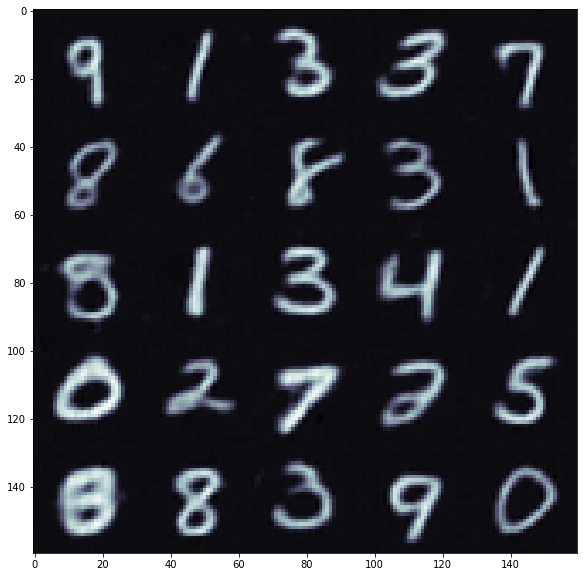

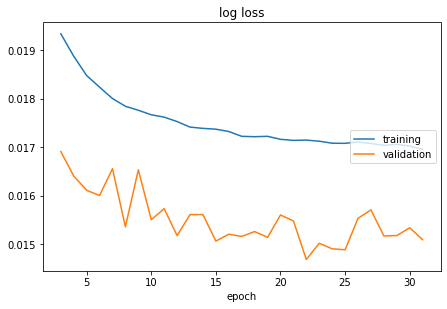

log loss:
training   (min:    0.017, max:    0.026, cur:    0.017)
validation (min:    0.015, max:    0.019, cur:    0.015)
Started Phase


KeyboardInterrupt: 

In [11]:
for epoch in range(NUM_EPOCHS):
    logs = {}
    t_start = time.time()
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
        model.to(device)
        
        print("Started Phase")

        running_loss = 0.0
                
        predicted_phase = torch.zeros(len(dataloaders[phase].dataset), 8)
        target_phase = torch.zeros(len(dataloaders[phase].dataset))
        
        if phase == 'validation':
            
            with torch.no_grad():
                
                recons = None
                
                for (i,batch) in enumerate(dataloaders[phase]):
                    input_tensor = batch[0]
                    bs = input_tensor.shape[0]

                    (recons, inp, mu, logvar) = model(torch.Tensor(input_tensor).to(device))

                    loss = vae_loss(inp,recons,mu,logvar)

                    input_tensor = input_tensor.cpu()
                    running_loss += loss.detach() * bs
                
                print(epoch)
                    
                if epoch % DISPLAY_STATE == 0:

                    plot_model_state(recons, epoch)
                
                
        
        else:
            
            for (i,batch) in enumerate(dataloaders[phase]):
                input_tensor = batch[0]
                bs = input_tensor.shape[0]
                
                (recons, inp, mu, logvar) = model(torch.Tensor(input_tensor).to(device))

                loss = vae_loss(inp,recons,mu,logvar)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                input_tensor = input_tensor.cpu()
                running_loss += loss.detach() * bs
    

        epoch_loss = running_loss / len(dataloaders[phase].dataset)

        
        model.to('cpu')

        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
#         logs[prefix + 'f1'] = epoch_f1.item()
#         logs[prefix + 'accuracy'] = epoch_accuracy.item()

        
        print('Phase time - ',time.time() - t_start)

    delta = time.time() - t_start
    is_better = logs['val_log loss'] < prev_acc
    if is_better:
        prev_acc = logs['val_log loss']
        torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'loss': logs['log loss']}, "../models/"+name+"_"+TIME_STAMP+"_"+str(logs['val_log loss'])+".pth")


    liveloss.update(logs)
    liveloss.draw()

In [ ]:
# b = None
# for (i, batch) in enumerate(train_loader):
#     b = batch
#     break

In [ ]:
# plot_model_state(b[0])

In [ ]:
# plot_model_state(model(torch.Tensor(b[0]).to(device))[0])

In [ ]:
rand_z = torch.randn([1, 10])
out = model.decode(rand_z.to(device))
plt.imshow(out.squeeze().cpu().detach().numpy(), cmap='bone')

In [ ]:
out